In [9]:
import os

model_path = os.path.join('sa', 'model')
if os.listdir(model_path) == None:
    print('resume')
else:
    print(os.listdir(model_path))


resume


100%|██████████| 406/406 [00:01<00:00, 237.83it/s]


{'samples1': [0.8471596777885282, 0.873884055188882, 0.8893082931211638, 0.8723122966476736, 0.8449436146566816, 0.8780908297727203, 0.8862977946326689, 0.8411908906976959, 0.8638960495407266, 0.8968581511136553, 0.8973868283857858, 0.8633108994759788, 0.8105718804608932, 0.8477207672995786, 0.846543698633854, 0.8905789139485583, 0.9021112293630996, 0.8298143976551517, 0.865383705746487, 0.8382121999465978, 0.8914414818019406, 0.8941878621124666, 0.808432589284393, 0.8734926528608924, 0.8352653526706987, 0.8756537772813694, 0.8710148337409973, 0.8042544323850274, 0.8273545752730864, 0.857166101861891, 0.8316103470051837, 0.8241731728828597, 0.8773842491846907, 0.764601660404002, 0.8654943168157081, 0.8754738278848858, 0.8567374528069751, 0.8470354937057013, 0.8628658871000401, 0.8708146736477809, 0.873403889632222, 0.8740548419810907, 0.8814214474558785, 0.8863063110675731, 0.873450012746795, 0.8128240726502283, 0.8572775495167457, 0.8838214782793667, 0.8728761906939178, 0.890250390306

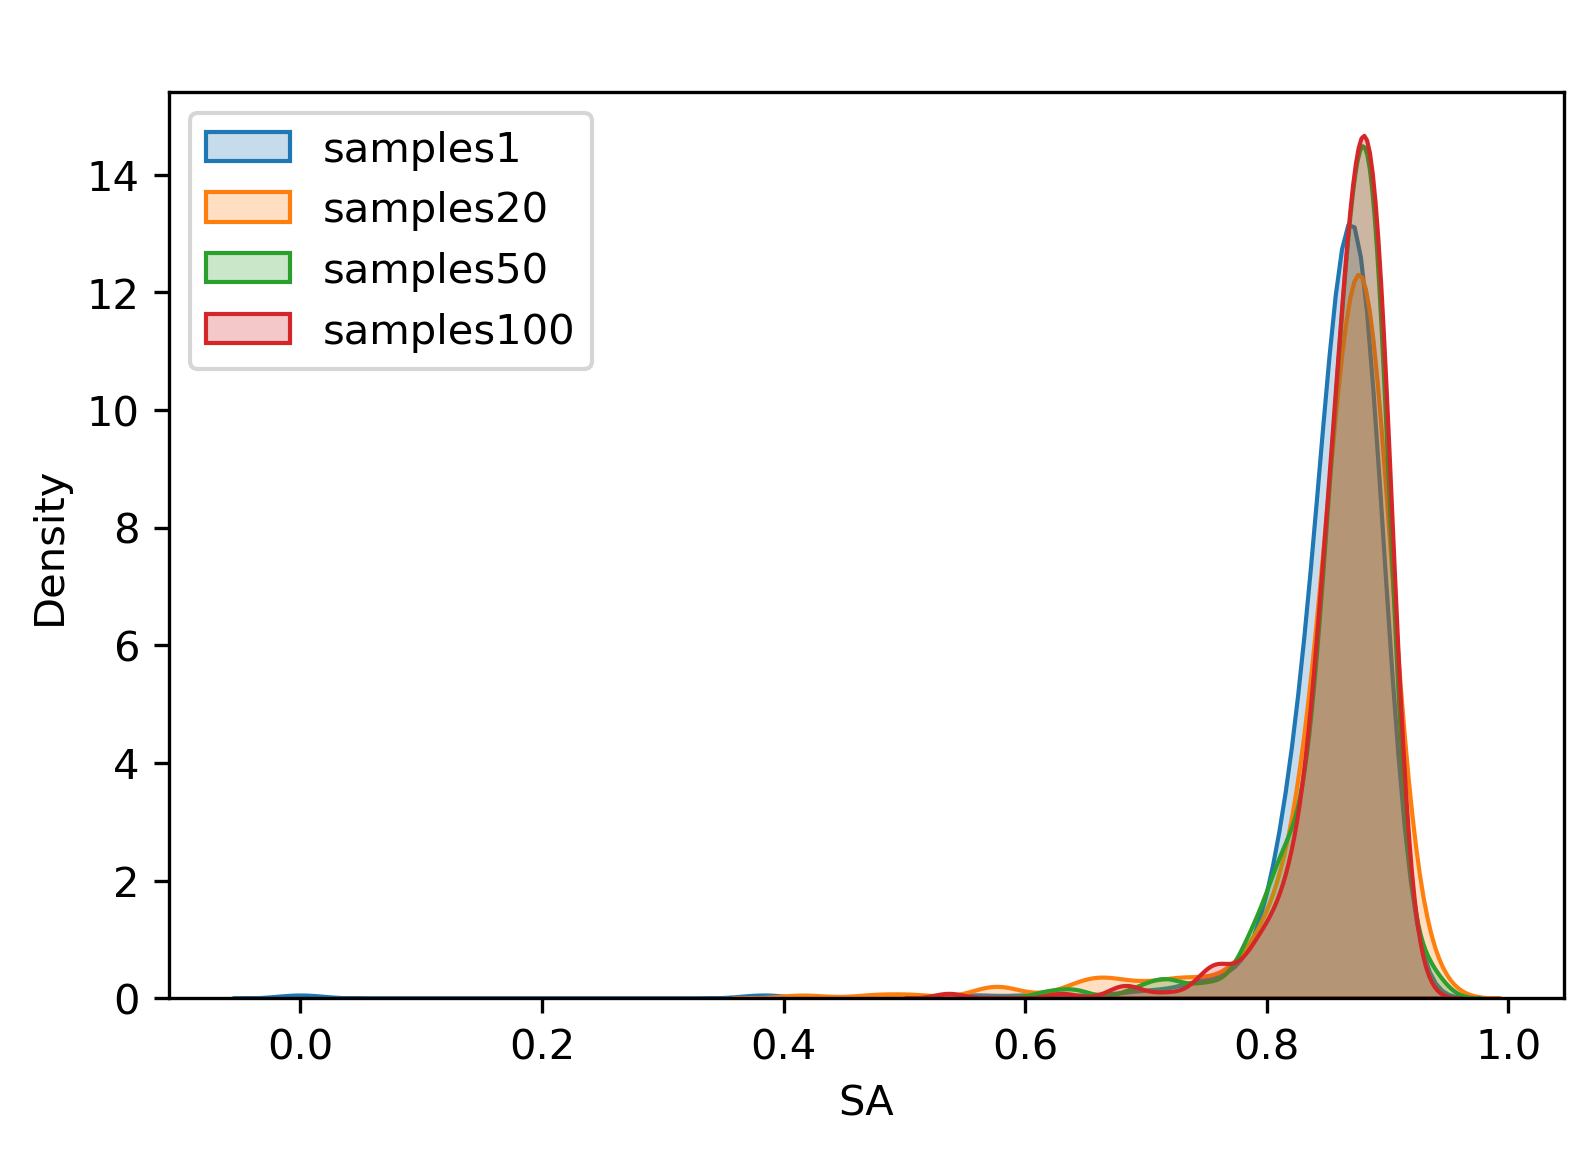

In [14]:
import argparse
import os
import os.path as op
import multiprocessing as mp
from optparse import OptionParser
from pdb import set_trace
import subprocess
from multiprocessing import Process
import sys
import math
import pickle

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from rdkit import Chem, RDLogger
from rdkit.Chem import Crippen, AllChem, rdMolDescriptors  
from src.datasets import read_sdf
from data.zinc import prepare_dataset as prep

# 禁用 RDKit 警告信息
RDLogger.DisableLog('rdApp.*')

def load_rdkit_molecule(xyz_path, obabel_path, true_frag_smi):
    if not os.path.exists(obabel_path):
        subprocess.run(f'obabel {xyz_path} -O {obabel_path}', shell=True)

    supp = Chem.SDMolSupplier(obabel_path, sanitize=False)
    mol = list(supp)[0]

    # Keeping only the biggest connected part
    mol_frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    mol_filtered = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    try:
        mol_smi = Chem.MolToSmiles(mol_filtered)
    except RuntimeError:
        mol_smi = Chem.MolToSmiles(mol_filtered, canonical=False)

    # Retrieving linker
    true_frag = Chem.MolFromSmiles(true_frag_smi, sanitize=False)
    match = mol_filtered.GetSubstructMatch(true_frag)# 遍历match的原子和剩下的其他原子，linker的原子，需要的是找linker的原子哪些有键
    if len(match) == 0:
        linker_smi = ''
    else:
        elinker = Chem.EditableMol(mol_filtered)
        for atom in sorted(match, reverse=True):
            elinker.RemoveAtom(atom)
        linker = elinker.GetMol()
        Chem.Kekulize(linker, clearAromaticFlags=True)
        try:
            linker_smi = Chem.MolToSmiles(linker)
        except RuntimeError:
            linker_smi = Chem.MolToSmiles(linker, canonical=False)

    return mol_filtered, mol_smi, linker_smi


def load_molecules(folder, true_frag_smi):
    obabel_dir = f'{folder}/obabel'
    os.makedirs(obabel_dir, exist_ok=True)

    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    for fname in os.listdir(folder):
        number = fname.split('_')[0]
        if number.isdigit():
            pred_path = f'{folder}/{fname}'
            pred_obabel_path = f'{obabel_dir}/{number}_.sdf'
            mol, mol_smi, link_smi = load_rdkit_molecule(pred_path, pred_obabel_path, true_frag_smi)
            pred_mols.append(mol)
            pred_mols_smi.append(mol_smi)
            pred_link_smi.append(link_smi)

    return pred_mols, pred_mols_smi, pred_link_smi


def load_sampled_dataset(folder, idx2true_mol_smi, idx2true_frag_smi):
    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    true_mols_smi = []
    true_frags_smi = []

    for fname in tqdm(os.listdir(folder)):
        if fname.isdigit():
            true_mol_smi = idx2true_mol_smi[int(fname)]
            true_frag_smi = idx2true_frag_smi[int(fname)]

            mols, mols_smi, link_smi = load_molecules(f'{folder}/{fname}', true_frag_smi)
            pred_mols += mols
            pred_mols_smi += mols_smi
            pred_link_smi += link_smi
            true_mols_smi += [true_mol_smi] * len(mols)
            true_frags_smi += [true_frag_smi] * len(mols)
    return pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frags_smi

def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    if name == "fpscores":
        name = op.join(os.getcwd(), name)
        # name = op.join(op.dirname(__file__), name)
    data = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict

def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro
 
 
def calculateScore(m):
    if _fscores is None:
        readFragmentScores()
    Chem.SanitizeMol(m)
    fp = rdMolDescriptors.GetMorganFingerprint(m,2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf
 
    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1
 
    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)
 
    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5
 
    sascore = score1 + score2 + score3

    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.

    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0
 
    return sascore


samples_no = [1,20,50,100]
true_smiles_path = 'datasets/zinc_final_test_smiles.smi'

true_smiles_table = pd.read_csv(true_smiles_path, sep=' ', names=['molecule', 'fragments'])
idx2true_mol_smi = dict(enumerate(true_smiles_table.molecule.values))
idx2true_frag_smi = dict(enumerate(true_smiles_table.fragments.values))

sa_dict = {} 

for i in samples_no:
    samples = f'sa/samples{i}'

    sa_key = f'samples{i}'

    pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frag_smi = load_sampled_dataset(
        folder=samples,
        idx2true_mol_smi=idx2true_mol_smi,
        idx2true_frag_smi=idx2true_frag_smi,
    )    
    sa_list = []
    lg_sa_list = []
    readFragmentScores("fpscores")
    for m in pred_mols:
        try:
            s = calculateScore(m)
            sa_list.append(s)
        except:
            sa_list.append('None')
            continue
    for s in sa_list:
        try:
            lg_sa = math.log10(s)
            lg_sa_list.append(lg_sa)
        except:
            lg_sa_list.append(s)
            continue
    
    sa_dict[sa_key] = lg_sa_list

print(sa_dict)
# # 绘制分布图
# for sa_key, sa_dict in sa_dict.items():
#     sns.kdeplot(sa_list, label=f'Distribution of {sa_key}', shade=True)

plt.figure(dpi=300)

for sa_key, sa_list in sa_dict.items():
    sns.kdeplot(sa_list, label=f'{sa_key}', shade=True)

# 添加标签和标题
plt.xlabel('SA')
plt.ylabel('Density')
plt.title('  ')

# 显示图例
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# 显示图形
plt.show()



  5%|▌         | 21/403 [00:00<00:01, 193.01it/s]

100%|██████████| 406/406 [00:00<00:00, 899.43it/s] 


{'samples1': [0.5457652716536301, 0.44037597447859483, 0.4091665423309728, 0.7595804791295275, 0.7653001339714102, 0.7034457576355098, 0.7290163692960212, 0.4376479893176818, 0.6846363950517668, 0.6436857514707082, 0.6309014496864928, 0.6112102087236421, 0.586060962583733, 0.46737607850551555, 0.605500360032351, 0.8646817242932224, 0.7323986790265233, 0.6469186685249747, 0.5104448428019581, 0.7809854319634946, 0.6316838303810355, 0.6943191472034449, 0.665312108200924, 0.6608345672080947, 0.5333461467648698, 0.5339975892962878, 0.5113172390895069, 0.4460869527177842, 0.6971623028732377, 0.5546515463322276, 0.5506656093786353, 0.5880204538399675, 0.5036629480855234, 0.6608834818627541, 0.5209864248573844, 0.5996396114698808, 0.5921800919208071, 0.646802382092894, 0.47218157394343235, 0.6534605365349411, 0.4454106690106119, 0.7508374400962903, 0.5330086772518622, 0.7124814975525596, 0.6707187297228894, 0.6399074867613475, 0.744165791822783, 0.6754502871048313, 0.6718089410659657, 0.621696

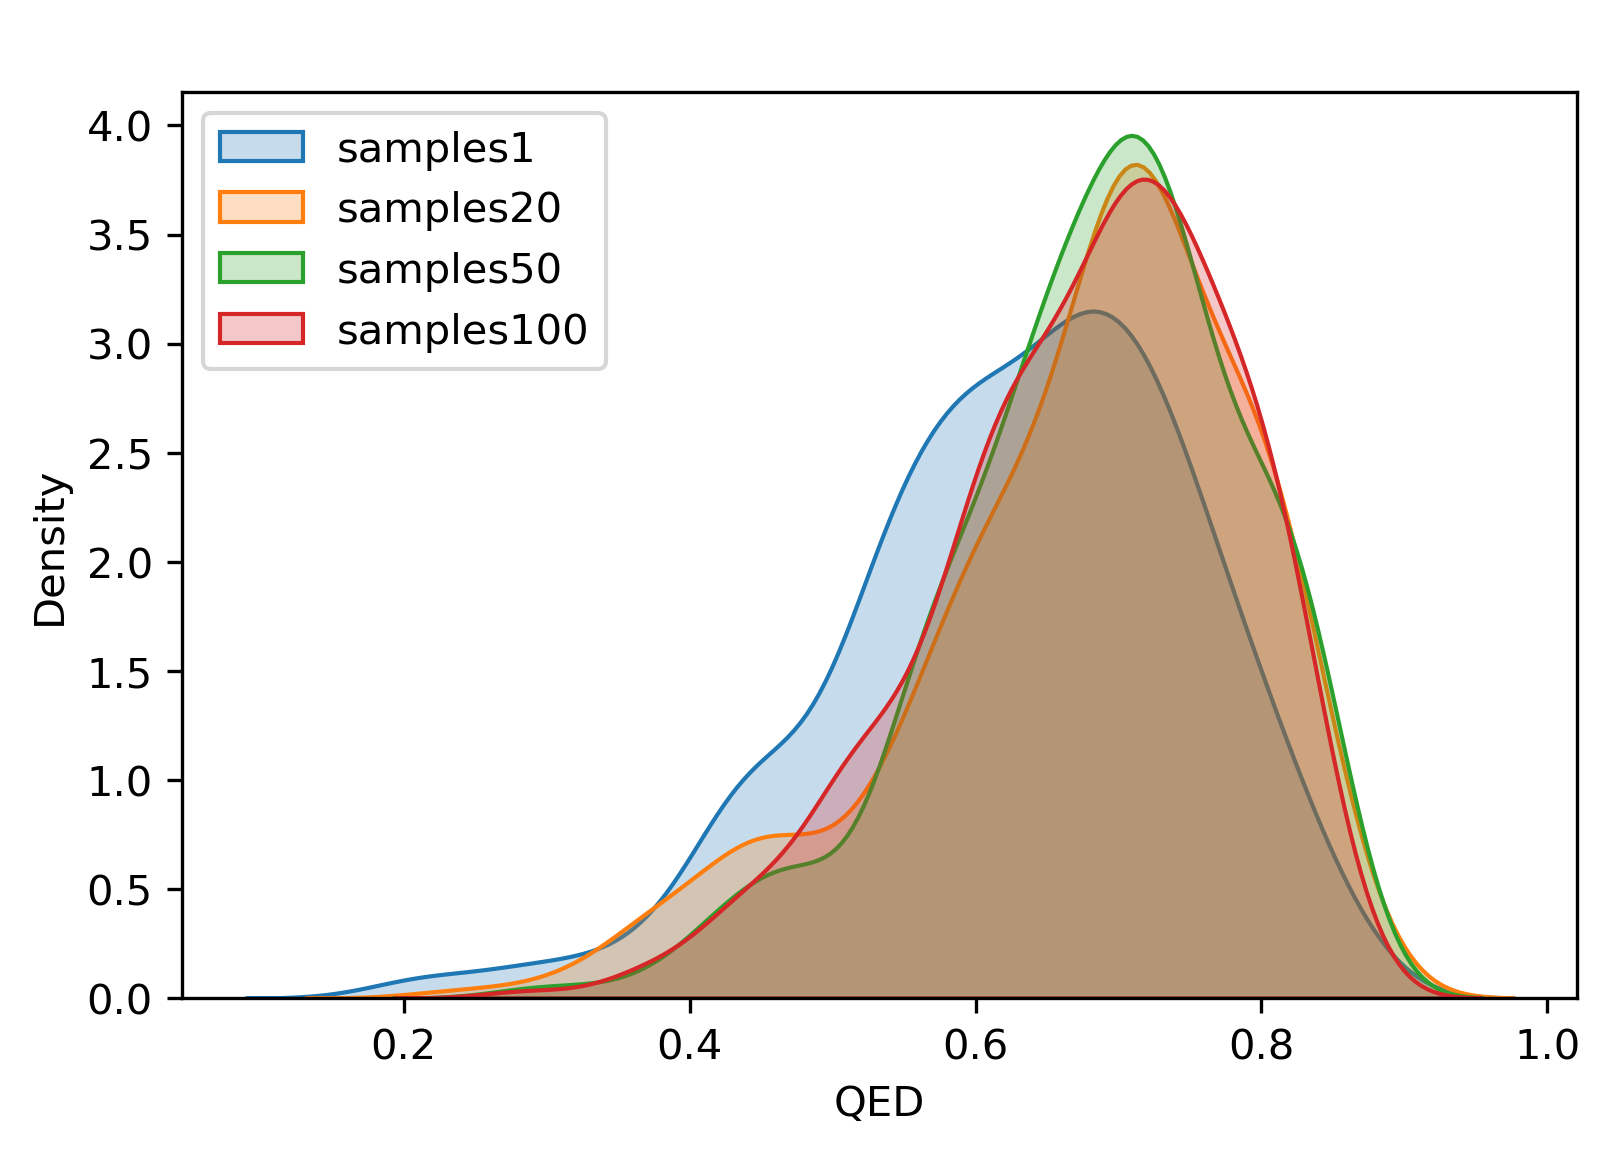

In [4]:
import argparse
import os
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Crippen,AllChem, QED
from tqdm import tqdm
from pdb import set_trace
import data.zinc.prepare_dataset as prep
import multiprocessing as mp
import sys
sys.path.append('../../')
from src.datasets import read_sdf
import subprocess
from multiprocessing import Process
from optparse import OptionParser

import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd
import logging

# 禁用 RDKit 警告信息
RDLogger.DisableLog('rdApp.*')

def load_rdkit_molecule(xyz_path, obabel_path, true_frag_smi):
    if not os.path.exists(obabel_path):
        subprocess.run(f'obabel {xyz_path} -O {obabel_path}', shell=True)

    supp = Chem.SDMolSupplier(obabel_path, sanitize=False)
    mol = list(supp)[0]

    # Keeping only the biggest connected part
    mol_frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    mol_filtered = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    try:
        mol_smi = Chem.MolToSmiles(mol_filtered)
    except RuntimeError:
        mol_smi = Chem.MolToSmiles(mol_filtered, canonical=False)

    # Retrieving linker
    true_frag = Chem.MolFromSmiles(true_frag_smi, sanitize=False)
    match = mol_filtered.GetSubstructMatch(true_frag)# 遍历match的原子和剩下的其他原子，linker的原子，需要的是找linker的原子哪些有键
    if len(match) == 0:
        linker_smi = ''
    else:
        elinker = Chem.EditableMol(mol_filtered)
        for atom in sorted(match, reverse=True):
            elinker.RemoveAtom(atom)
        linker = elinker.GetMol()
        Chem.Kekulize(linker, clearAromaticFlags=True)
        try:
            linker_smi = Chem.MolToSmiles(linker)
        except RuntimeError:
            linker_smi = Chem.MolToSmiles(linker, canonical=False)

    return mol_filtered, mol_smi, linker_smi


def load_molecules(folder, true_frag_smi):
    obabel_dir = f'{folder}/obabel'
    os.makedirs(obabel_dir, exist_ok=True)

    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    for fname in os.listdir(folder):
        number = fname.split('_')[0]
        if number.isdigit():
            pred_path = f'{folder}/{fname}'
            pred_obabel_path = f'{obabel_dir}/{number}_.sdf'
            mol, mol_smi, link_smi = load_rdkit_molecule(pred_path, pred_obabel_path, true_frag_smi)
            pred_mols.append(mol)
            pred_mols_smi.append(mol_smi)
            pred_link_smi.append(link_smi)

    return pred_mols, pred_mols_smi, pred_link_smi


def load_sampled_dataset(folder, idx2true_mol_smi, idx2true_frag_smi):
    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    true_mols_smi = []
    true_frags_smi = []

    for fname in tqdm(os.listdir(folder)):
        if fname.isdigit():
            true_mol_smi = idx2true_mol_smi[int(fname)]
            true_frag_smi = idx2true_frag_smi[int(fname)]

            mols, mols_smi, link_smi = load_molecules(f'{folder}/{fname}', true_frag_smi)
            pred_mols += mols
            pred_mols_smi += mols_smi
            pred_link_smi += link_smi
            true_mols_smi += [true_mol_smi] * len(mols)
            true_frags_smi += [true_frag_smi] * len(mols)
# fragment 原始数据 
    return pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frags_smi

samples_no = [1,20,50,100]
true_smiles_path = 'datasets/zinc_final_test_smiles.smi'

true_smiles_table = pd.read_csv(true_smiles_path, sep=' ', names=['molecule', 'fragments'])
idx2true_mol_smi = dict(enumerate(true_smiles_table.molecule.values))
idx2true_frag_smi = dict(enumerate(true_smiles_table.fragments.values))

qed_dict = {} 

for i in samples_no:
    samples = f'qed/samples{i}'

    qed_key = f'samples{i}'

    pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frag_smi = load_sampled_dataset(
        folder=samples,
        idx2true_mol_smi=idx2true_mol_smi,
        idx2true_frag_smi=idx2true_frag_smi,
    )    

    qed_list = []
    for m in pred_mols:
        try:
            Chem.SanitizeMol(m)
            Chem.AssignStereochemistry(m, force=True, cleanIt=True)
            mol = Chem.AddHs(m)
            qed = QED.qed(mol)
            qed_list.append(qed)
        except:
            continue
    
    qed_dict[qed_key] = qed_list

print(qed_dict)
# # 绘制分布图
# for qed_key, qed_dict in qed_dict.items():
#     sns.kdeplot(qed_list, label=f'Distribution of {qed_key}', shade=True)

plt.figure(dpi=300)

for qed_key, qed_list in qed_dict.items():
    sns.kdeplot(qed_list, label=f'{qed_key}', shade=True)

# 添加标签和标题
plt.xlabel('QED')
plt.ylabel('Density')
plt.title('  ')

# 显示图例
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# 显示图形
plt.show()


